In [1]:
using Plots
using LES_ML
using LaTeXStrings
using CUDA

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [3]:
FA_filter = gen_FA_filter(J,2) |> gpu


UndefVarError: UndefVarError: `gen_FA_filter` not defined

In [4]:
N = (256,256)
UPC = 2       


x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = true)

# number of unknowns per cell

J = (16,16) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0



0

In [5]:
forcing(x) = sin.(4*x[2])

F = fine_mesh.eval_function(forcing)
F = cat(F,cu(zeros(size(F))),dims = fine_mesh.dims + 1)



256×256×2×1 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 0.0490675  0.146731  0.242981  0.33689  …  -0.242981  -0.146731  -0.0490675
 0.0490675  0.146731  0.242981  0.33689     -0.242981  -0.146731  -0.0490675
 0.0490675  0.146731  0.242981  0.33689     -0.242981  -0.146731  -0.0490675
 0.0490675  0.146731  0.242981  0.33689     -0.242981  -0.146731  -0.0490675
 0.0490675  0.146731  0.242981  0.33689     -0.242981  -0.146731  -0.0490675
 0.0490675  0.146731  0.242981  0.33689  …  -0.242981  -0.146731  -0.0490675
 0.0490675  0.146731  0.242981  0.33689     -0.242981  -0.146731  -0.0490675
 0.0490675  0.146731  0.242981  0.33689     -0.242981  -0.146731  -0.0490675
 0.0490675  0.146731  0.242981  0.33689     -0.242981  -0.146731  -0.0490675
 0.0490675  0.146731  0.242981  0.33689     -0.242981  -0.146731  -0.0490675
 ⋮                                       ⋱                         ⋮
 0.0490675  0.146731  0.242981  0.33689     -0.242981  -0.146731  -0.0490675
 0.0490675  0.146

In [6]:
setup = gen_setup(fine_mesh)
setup_bar = gen_setup(coarse_mesh)

LES_ML.setup_struct(LES_ML.operators_struct(Conv((3, 3), 2 => 1, bias=false), Conv((3, 3), 1 => 2, bias=false), LES_ML.var"#C#143"{Float32, Int64}(0.3926991f0, Core.Box(Conv((3, 3), 2 => 4, bias=false)), Core.Box(Conv((3, 3), 2 => 4, bias=false)), 2, Core.Box(Conv((3, 3), 4 => 2, bias=false))), Conv((3, 3), 2 => 2, bias=false), Conv((3, 3), 2 => 1, bias=false)), LES_ML.var"#pressure_poisson#97"{LES_ML.var"#pressure_poisson#89#98", CuArray{Float32, 4, CUDA.DeviceMemory}}(LES_ML.var"#pressure_poisson#89#98"(Core.Box(2)), Core.Box(Float32[0.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]), Float32[1.0 0.98721313 … 3.798563 0.98721313; 0.98721313 1.9744282 … 4.785778 1.9744282; … ; 3.798563 4.785778 … 7.597128 4.785778; 0.98721313 1.9744282 … 4.785778 1.9744282;;;;]), LES_ML.grid_swapper(LES_ML.mesh_struct(2, (16, 16), Float32[-2.9452431 -2.9452431 … -2.9452431 -2.9452431; -2.552544 -2.552544 … -2.552544 -2.552544; … ; 2.552544 2.552544 … 2.552544 2.552544; 2.

In [7]:
setup.O.G.weight

3×3×1×2 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 0.0    0.0     0.0
 0.0  -40.7437  0.0
 0.0   40.7437  0.0

[:, :, 1, 2] =
 0.0    0.0      0.0
 0.0  -40.7437  40.7437
 0.0    0.0      0.0

In [8]:
max_k = 10
energy_norm = 1
number_of_simulations = 1

setup = gen_setup(fine_mesh)
KF_rhs = gen_rhs(setup,0*F;Re = 1000,damping = 0.1)

V = cu(gen_random_field(fine_mesh.N,max_k,norm = energy_norm,samples = (fine_mesh.UPC,number_of_simulations)))


    
MV = setup.O.M(padding(V,(1,1),circular = true))



p = setup.PS(MV)

Gp = setup.O.G(padding(p,(1,1),circular =true))

V0 = V-Gp

setup.O.M(V0)[:,:,1,1]

KF_rhs(V0,fine_mesh,0)


256×256×2×1 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 -3.41076  -3.20001   -2.91834     …  -3.42568   -3.53892  -3.52974
 -3.35286  -3.07979   -2.74409        -3.57901   -3.62084  -3.54025
 -3.23968  -2.90073   -2.50863        -3.69295   -3.65715  -3.49996
 -3.07772  -2.67068   -2.22039        -3.76792   -3.6504   -3.41315
 -2.87442  -2.39867   -1.89007        -3.80552   -3.60485  -3.28609
 -2.63835  -2.09509   -1.52876     …  -3.80839   -3.52486  -3.12553
 -2.37844  -1.7702    -1.14846        -3.77952   -3.41562  -2.93849
 -2.10343  -1.43406   -0.760721       -3.7213    -3.28182  -2.73142
 -1.8205   -1.09606   -0.376168       -3.63574   -3.12713  -2.51013
 -1.53563  -0.763843  -0.00433314     -3.52407   -2.95403  -2.27902
  ⋮                                ⋱                        ⋮
 -1.40773  -1.44275   -1.41438        -0.906447  -1.13717  -1.3057
 -1.80125  -1.84297   -1.81148        -1.21207   -1.48402  -1.68171
 -2.16876  -2.20878   -2.16821        -1.52719   -1.8272

In [10]:
heatmap(Array(FA_filter(V0))[:,:,2,1])

UndefVarError: UndefVarError: `FA_filter` not defined

In [11]:
dt = 0.01
save_every = 10
t_start = 0
t_end = 5
pre_allocate = true

t_data,sim_data = simulate(V0,fine_mesh,dt,t_start,t_end,KF_rhs,save_every = save_every,pre_allocate = pre_allocate) 
0

0.0%┣                                            ┫ 0/500 [00:04<-36:-16, -4s/it]
0.2%┣                                          ┫ 1/500 [00:06<Inf:Inf, InfGs/it]
0.4%┣▏                                              ┫ 2/500 [00:06<51:39, 6s/it]
1.2%┣▋                                              ┫ 6/500 [00:06<10:22, 1s/it]
2.0%┣█                                             ┫ 10/500 [00:08<07:18, 1it/s]
3.0%┣█▍                                            ┫ 15/500 [00:08<04:41, 2it/s]
4.0%┣█▉                                            ┫ 20/500 [00:08<03:26, 2it/s]
4.8%┣██▏                                           ┫ 24/500 [00:08<02:50, 3it/s]
5.6%┣██▋                                           ┫ 28/500 [00:08<02:25, 3it/s]
6.4%┣███                                           ┫ 32/500 [00:08<02:06, 4it/s]
7.2%┣███▎                                          ┫ 36/500 [00:08<01:51, 4it/s]
8.0%┣███▊                                          ┫ 40/500 [00:08<01:39, 5it/s]
8.8%┣████                   

0

┌ Info: Saved animation to /gpfs/home6/tvangastelen/projects/LES_ML.jl/DNS_flow.gif
└ @ Plots /home/tvangastelen/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/gpfs/home6/tvangastelen/projects/LES_ML.jl/DNS_flow.gif")
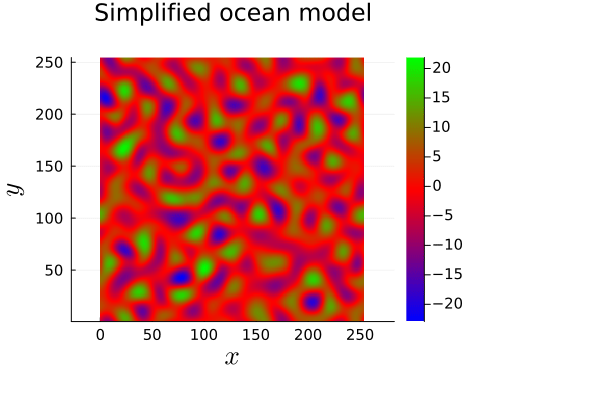

In [12]:
to_plot = Array(setup.O.w(sim_data[:,:,:,1,:]))[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]


ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Simplified ocean model",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

In [13]:
E = Array(fine_mesh.ip(sim_data,sim_data))[1:end]
E_bar = Array(coarse_mesh.ip(MP.FA_filter(sim_data[:,:,:,1,:]),MP.FA_filter(sim_data[:,:,:,1,:])))[1:end]

50-element Vector{Float32}:
 25.56472
 24.865942
 24.549442
 24.629562
 24.76631
 24.54678
 23.854774
 23.16251
 22.612185
 22.132904
  ⋮
 11.721448
 11.482973
 11.251524
 11.013195
 10.768854
 10.525864
 10.285406
 10.043697
  9.806681

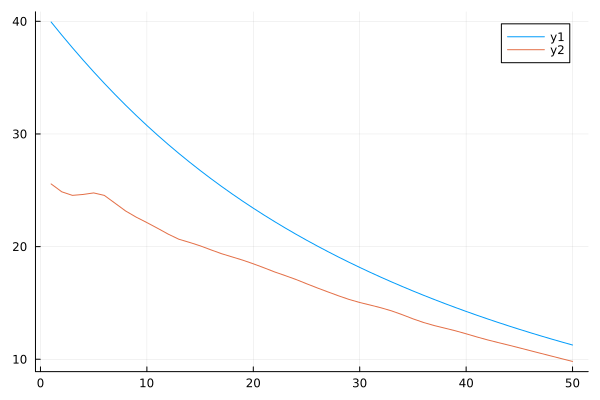

In [14]:
plot(E)
plot!(E_bar)

In [15]:
MP.FA_filter(sim_data[:,:,:,1,:])

16×16×2×50 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
  0.680828   -0.0707654   0.0246801  …  -0.494525    0.931354    0.420242
  0.743685   -0.560745    0.135306       0.193132   -0.439075    0.725561
  0.188147    0.23823    -1.28138        0.131755   -0.551793    0.902042
 -0.0312906   0.364814   -0.790203      -0.707686    0.81893     0.257993
 -0.0324488  -0.534907   -0.308685       1.29305     0.543768    0.0377149
  0.337593   -0.0215307  -0.975988   …   0.362023    0.103833    0.215604
 -0.43063     0.434516    0.940314       0.309586    0.801157   -0.215391
 -0.135946   -0.359226    0.78177       -0.295467    0.307832    0.329418
  0.0444384   0.504011   -0.328694       0.885161    0.195729   -0.068988
  0.426017   -0.567299   -0.250473       0.658868   -0.16505     0.436527
 -0.119897   -1.09212     0.422925   …   0.0281739   0.223886    0.81159
  0.576887   -0.694906    0.0569623      0.840244    0.0524218  -0.224548
  0.150238   -0.0380947  -0.797369       1.717

In [16]:
setup.O

LES_ML.operators_struct(Conv((3, 3), 2 => 1, bias=false), Conv((3, 3), 1 => 2, bias=false), LES_ML.var"#C#143"{Float32, Int64}(0.024543693f0, Core.Box(Conv((3, 3), 2 => 4, bias=false)), Core.Box(Conv((3, 3), 2 => 4, bias=false)), 2, Core.Box(Conv((3, 3), 4 => 2, bias=false))), Conv((3, 3), 2 => 2, bias=false), Conv((3, 3), 2 => 1, bias=false))

In [17]:
using Flux

struct smagorinsky_operators_struct
    S
    SS
    div
end

function gen_permutations(N)

    N_grid = [collect(1:n) for n in N]

    sub_grid = ones(Int,(N...))

    dims = length(N)
    sub_grids = []

    for i in 1:dims
        original_dims = collect(1:dims)
        permuted_dims = copy(original_dims)
        permuted_dims[1] = original_dims[i]
        permuted_dims[i] = 1


        push!(sub_grids,permutedims(N_grid[i] .*  permutedims(sub_grid,permuted_dims),permuted_dims))

    end

    return reverse(reshape(cat(sub_grids...,dims = dims + 1),(prod(N)...,dims)),dims =2 )
end


function gen_smagorinsky_operators(mesh)
    dims = mesh.dims
    use_GPU = mesh.use_GPU
    h = CUDA.@allowscalar(mesh.dx[1])


    UPC = mesh.UPC

    @assert dims != 3 "Convection for dims = 3 is not yet supported"

    stenc_3 = zeros(([3 for i in 1:dims]...))
    select = [(:);[2 for i in 1:dims-1]]

    div = Conv(([3 for i in 1:dims]...,), UPC=>1,stride = ([1 for i in 1:dims]...,),pad = 0,bias =false)  # First convolution, operating upon a 28x28 image
    for i in 1:UPC
        
        for j in 1:UPC
            stencil = copy(stenc_3)
            if i == j 
                stencil[circshift(select,(i-1,))...] .= 1/h * [0,-1,1]
            end
            div.weight[[(:) for k in 1:dims]...,i,1] .= stencil
        end
    end


    S = Conv(([3 for i in 1:dims]...,), UPC=>sum(collect(1:UPC)),stride = ([1 for i in 1:dims]...,),pad = 0,bias =false)  # First convolution, operating upon a 28x28 image
    S.weight .= 0
    perms = gen_permutations((dims,dims))
    counter = 1
    for i in 1:size(perms)[1]
        perm = perms[i,:]
        index_1 = perm[1]
        index_2 = perm[2]
        

        stencil_1 = copy(stenc_3)
        stencil_2 = copy(stenc_3)
        stencil_1[circshift(select,(index_1-1,))...] .= 1/(2*h) * [1,-1,0]
        stencil_2[circshift(select,(index_2-1,))...] .= 1/(2*h) * [1,-1,0]

        if index_1 <= index_2 
            S.weight[[(:) for k in 1:dims]...,index_2,counter] .+= stencil_1
            S.weight[[(:) for k in 1:dims]...,index_1,counter] .+= stencil_2
            counter += 1
        end
    end
    

    div = Conv(([3 for i in 1:dims]...,), sum(collect(1:UPC))=>UPC,stride = ([1 for i in 1:dims]...,),pad = 0,bias =false)  # First convolution, operating upon a 28x28 image
    perms = gen_permutations((dims,dims))
    counter = 1
    div.weight .= 0
    for i in 1:size(perms)[1]
        perm = perms[i,:]
        index_1 = perm[1]
        index_2 = perm[2]
        

        stencil_1 = copy(stenc_3)
        stencil_2 = copy(stenc_3)
        stencil_1[circshift(select,(index_1-1,))...] .= 1/h * [0,-1,1]
        stencil_2[circshift(select,(index_2-1,))...] .= 1/h * [0,-1,1]

        if index_1 <= index_2 
            div.weight[[(:) for k in 1:dims]...,counter,index_2] .= stencil_1
            div.weight[[(:) for k in 1:dims]...,counter,index_1] .= stencil_2
            counter += 1
        end
    end


    SS = Conv(([1 for i in 1:dims]...,), sum(collect(1:UPC))=>1,stride = ([1 for i in 1:dims]...,),pad = 0,bias =false)  # First convolution, operating upon a 28x28 image
    perms = gen_permutations((dims,dims))
    counter = 1
    SS.weight .= 1
    for i in 1:size(perms)[1]
        perm = perms[i,:]
        index_1 = perm[1]
        index_2 = perm[2]
        


        if index_1 <= index_2 
            if index_1 != index_2
                SS.weight[[(:) for k in 1:dims]...,counter,1] .= 2
            end
            counter += 1
        end
    end



    if use_GPU
        div = div |> gpu
        S = S |> gpu
        SS = SS |> gpu

    end



    return smagorinsky_operators_struct(S,SS,div)#,Q,Q_T,D
end

gen_smagorinsky_operators (generic function with 1 method)

In [18]:
SO = gen_smagorinsky_operators(fine_mesh)
SO.SS.weight

1×1×3×1 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 1.0

[:, :, 2, 1] =
 2.0

[:, :, 3, 1] =
 1.0

In [19]:
u_bar = MP.FA_filter(sim_data[:,:,:,1,:])

16×16×2×50 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
  0.680828   -0.0707654   0.0246801  …  -0.494525    0.931354    0.420242
  0.743685   -0.560745    0.135306       0.193132   -0.439075    0.725561
  0.188147    0.23823    -1.28138        0.131755   -0.551793    0.902042
 -0.0312906   0.364814   -0.790203      -0.707686    0.81893     0.257993
 -0.0324488  -0.534907   -0.308685       1.29305     0.543768    0.0377149
  0.337593   -0.0215307  -0.975988   …   0.362023    0.103833    0.215604
 -0.43063     0.434516    0.940314       0.309586    0.801157   -0.215391
 -0.135946   -0.359226    0.78177       -0.295467    0.307832    0.329418
  0.0444384   0.504011   -0.328694       0.885161    0.195729   -0.068988
  0.426017   -0.567299   -0.250473       0.658868   -0.16505     0.436527
 -0.119897   -1.09212     0.422925   …   0.0281739   0.223886    0.81159
  0.576887   -0.694906    0.0569623      0.840244    0.0524218  -0.224548
  0.150238   -0.0380947  -0.797369       1.717

In [20]:
function smagorinsky_model(u_bar,mesh,Cs,SO)
    h =  stop_gradient() do 
        CUDA.@allowscalar(mesh.dx[1])
    end
    u_pad = padding(u_bar,(2,2),circular = true)
    S = SO.S(u_pad)
    SS = sqrt.(SO.SS(S.^2))
    vt = padding(Cs.^2,(1,1),circular = true) .* SS
    return SO.div(h * vt .* S)
end

function div_model(tau,mesh,SO)
    
    tau_pad = padding(tau,(1,1),circular = true)

    return SO.div(tau_pad)
end

smagorinsky_model (generic function with 1 method)

In [21]:
lit = smagorinsky_model(u_bar,coarse_mesh,1,SO)
Cs = cu(rand(Normal(0,1),(size(sim_data)[1:2].+2)))
lit2 = smagorinsky_model(sim_data[:,:,:,1,:],coarse_mesh,Cs,SO)
plot(Array(fine_mesh.ip(sim_data[:,:,:,1,:],lit2))[1:end])

UndefVarError: UndefVarError: `Normal` not defined

In [22]:
heatmap(Array(lit2)[:,:,1,1])

UndefVarError: UndefVarError: `lit2` not defined

In [23]:
using Distributions
